In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize
#from numpy import zeros
#from pickle import dump
#from os import chdir

In [2]:
# Loading custom defined functions
#wd = open('wd.cfg').read()
#chdir(wd)
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, clean_strings, get_redundaunt_info, is_in_words
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger

In [3]:
DetectorFactory.seed = 0

in_file = open("in_file.cfg").read()
in_file = in_file.split("\n")
patterns_file = in_file[5]
file_folder = in_file[4]
label = in_file[3]
col = in_file[2]
in_type = in_file[1]
in_file = in_file[0]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)
    patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

In [4]:
redundant = get_redundaunt_info(strings)
total_redundant = redundant.sum()

In [5]:
from re import findall
unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
unnecessary = unnecessary1 | unnecessary2
total_unnecessary = unnecessary.sum()

In [6]:
# Deduplication
strings = filter_senders(strings)
strings = filter_recipients(strings)
strings = filter_data(strings)

In [7]:
strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
strings = strings['messages'].reset_index(drop = True)
strings = strings.apply(lambda x: " ".join(x))
strings = strings.apply(clean_strings)

In [8]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]
# hit_strings = strings[hits]

In [9]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

In [10]:
# Processing English sentences:
# 1) Splitting sentences
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len).tolist()
# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

In [11]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: " ".join(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

In [12]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

In [13]:
sentences1

0    1conversation started joined conversation guy ...
1    conversation started joined conversation guy i...
Name: messages, dtype: object

In [14]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [15]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

In [16]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")

out_file.close()

In [17]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

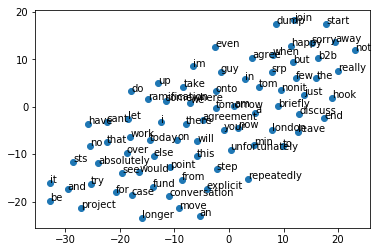

In [18]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

In [19]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

In [20]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

In [21]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [22]:
sim1 = get_semantic_similarity(model)

In [23]:
vocab = list(model.wv.vocab)

In [24]:
ratio = get_character_similarity(vocab, 'ratio')

In [25]:
partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [26]:
token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [27]:
token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [28]:
sim1 = sim1[ratio.columns]
sim1 = sim1.loc[ratio.columns]

In [29]:
semantic_weight = 0.5
ratio_weight = 0.4
partial_ratio_weight = 0.4
token_sort_ratio_weight = 0.1
sim = 1 - (semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight))

In [30]:
aff = run_aff_prop_with_distances(sim)

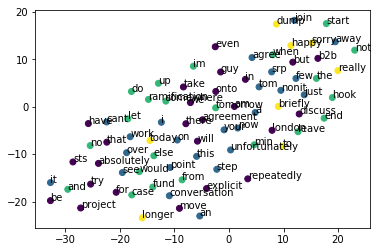

In [31]:
visualize_word2vec_model(model, aff.labels_)

In [32]:
columns = sim.columns
condition = Series(sim.columns).apply(is_in_words)
sim = sim.loc[columns[~condition]]
sim = sim[columns[condition]]

In [33]:
sim.apply(lambda x: x.sort_values().index[0], axis = 1)

b2b               be
cant              an
im                 i
nonit             it
ramification      on
srp               up
sts             step
dtype: object